DHCG Tunability Optimization

> Optimizate tunability; defined as distance between peaks divided by average FWHM

Conditions
- SiO2 Thickness under 3um
- Graphene Fermi energy between 0.05eV and 0.6eV
- Si thickness under 1um
- P shorter than wavelength (suppress diffraction)

In [ ]:
import pandas as pd
import numpy as np
import torch
import meent
import matplotlib.pyplot as plt
import time


# Refractive Indices

In [51]:
def get_SiO2_index(wavelength):
    sio2_data = pd.read_csv('C:\\Users\\user\\DHCG\\Refractive Index\\SiO2_n.csv')
    # Interpolate the refractive index
    n_sio2 = np.interp(wavelength,  pd.to_numeric(sio2_data['wl']),  pd.to_numeric(sio2_data['n']))
    
    sio2_data = pd.read_csv('C:\\Users\\user\\DHCG\\Refractive Index\\SiO2_k.csv')
    # Interpolate the refractive index
    k_sio2 = np.interp(wavelength,  pd.to_numeric(sio2_data['wl']),  pd.to_numeric(sio2_data['k'])) 

    return n_sio2 - 1j* k_sio2

In [52]:
def get_Si_index(wavelength):
    si_data = pd.read_csv('C:\\Users\\user\\DHCG\\Refractive Index\\Si_n.csv')
    # Interpolate the refractive index
    n_si = np.interp(wavelength,  pd.to_numeric(si_data['wl']),  pd.to_numeric(si_data['n']))
    
    si_data = pd.read_csv('C:\\Users\\user\\DHCG\\Refractive Index\\Si_k.csv')
    # Interpolate the refractive index
    k_si = np.interp(wavelength,  pd.to_numeric(si_data['wl']),  pd.to_numeric(si_data['k'])) 

    return n_si - 1j* k_si

In [53]:
def get_Au_index(wavelength):
    au_data = pd.read_csv('C:\\Users\\user\\DHCG\\Refractive Index\\Evaporated Gold_Olmon_n.csv')
    n_au = np.interp(wavelength, au_data['wl'], au_data['n']) 
    
    au_data = pd.read_csv('C:\\Users\\user\\DHCG\\Refractive Index\\Evaporated Gold_Olmon_k.csv')
    k_au = np.interp(wavelength, au_data['wl'], au_data['k']) 

    return n_au - 1j*k_au

In [54]:
def get_graphene_index_005eV(wavelength):
    graphene_data = pd.read_csv('C:\\Users\\user\\DHCG\\Refractive Index\\Graphene\\Graphene_SJ\\GR_005ev_n.csv')
    # Interpolate the refractive index
    n_graphene = np.interp(wavelength,  pd.to_numeric(graphene_data['wl']),  pd.to_numeric(graphene_data['n']))
    
    graphene_data = pd.read_csv('C:\\Users\\user\\DHCG\\Refractive Index\\Graphene\\Graphene_SJ\\GR_005ev_k.csv')
    # Interpolate the refractive index
    k_graphene = np.interp(wavelength,  pd.to_numeric(graphene_data['wl']),  pd.to_numeric(graphene_data['k'])) 

    return n_graphene - 1j* k_graphene

In [55]:
def get_graphene_index_060eV(wavelength):
    graphene_data = pd.read_csv('C:\\Users\\user\\DHCG\\Refractive Index\\Graphene\\Graphene_SJ\\GR_060ev_n.csv')
    # Interpolate the refractive index
    n_graphene = np.interp(wavelength,  pd.to_numeric(graphene_data['wl']),  pd.to_numeric(graphene_data['n']))
    
    graphene_data = pd.read_csv('C:\\Users\\user\\DHCG\\Refractive Index\\Graphene\\Graphene_SJ\\GR_060ev_k.csv')
    # Interpolate the refractive index
    k_graphene = np.interp(wavelength,  pd.to_numeric(graphene_data['wl']),  pd.to_numeric(graphene_data['k'])) 

    return n_graphene - 1j* k_graphene

In [56]:
#n_Si = 3.5 # Reference Value
n_Si = 3.5-0.067j # Measured Value
target_wl = 5700

In [57]:
def create_solver(fto, pol, wavelength, period_x, period_y, d, t):
    backend = 2  # Torch 0 means Jax, 1 means numpy(Fastest, can't be autograd), 2 means torch
    device = 0 # 0 : CPU, 1 : GPU
    pol = pol # 0: TE, 1: TM

    n_top = 1   # n_incidence = Air
    n_bot = 1   # get_Au_index(wavelength.item()/1000)  # n_transmission = Au
    
    theta = 0 * torch.pi / 180  # angle of incidence
    phi_rcwa = 0 * torch.pi / 180  # angle of rotation

    graphene_thickness = torch.tensor(0.34, dtype=torch.float64)
    d_Au = torch.tensor(1000, dtype=torch.float64)

    # thickness of each layer, from the first layer Air to Au

    thickness = torch.stack([t, graphene_thickness, d, d_Au])

    period = [period_x, period_y]  # length of the unit cell. Here it's 1D.

    type_complex = torch.complex128

    #Fourier order is subject to change
    mee = meent.call_mee(backend=backend, pol=pol,
                        n_top=n_top, n_bot=n_bot, theta=theta, phi=phi_rcwa,
                        fto=fto, wavelength=wavelength, period=period,
                        thickness=thickness, type_complex=type_complex,
                        device=device, fourier_type=0)

    return mee

In [58]:
def forward_single(mee, input_length_x,input_length_y, centers, n_indices):

    length_x = []
    length_y = []
    
    
    for length in input_length_x:
        length_x.append(length.type(torch.complex128))
    
    for length in input_length_y:
        length_y.append(length.type(torch.complex128))

    # Implement Silicon Blocks
    Si_block_1 = ['rectangle',*centers[0], length_x[0], length_y[0], n_indices[0], 0, 0, 0] # mee.rectangle(*centers[0], length_x[0], length_y[0], n_indices[0])
    Si_block_2 = ['rectangle',*centers[1], length_x[1], length_y[1], n_indices[1], 0, 0, 0] # mee.rectangle(*centers[1], length_x[1], length_y[1], n_indices[1])

    Si_blocks_list = [Si_block_1, Si_block_2]

    # Implement graphene layer
    Graphene = ['rectangle',*centers[2], length_x[2], length_y[2], n_indices[2], 0, 0, 0] # mee.rectangle(*centers[2], length_x[2], length_y[2], n_indices[2])

    # Implement graphene layer
    SiO2 = ['rectangle',*centers[3], length_x[3], length_y[3], n_indices[3], 0, 0, 0] # mee.rectangle(*centers[3], length_x[3], length_y[3], n_indices[3])

    # Implement gold back reflector
    Au = ['rectangle',*centers[4], length_x[4], length_y[4], n_indices[4], 0, 0, 0] # mee.rectangle(*centers[2], length_x[2], length_y[2], n_indices[2])

    layer_info_list = [[n_indices[-1], Si_blocks_list], [n_indices[2], [Graphene]], [n_indices[3], [SiO2]], [n_indices[4], [Au]]] # Si blocks, graphene, SiO2 in order

    mee.ucell = layer_info_list
    
    de_ri, de_ti = mee.conv_solve()

    return de_ri, de_ti

In [59]:
def find_target_wl(center, length_x, length_y, period_x, period_y, d, t, ev):

    wavelengths = torch.linspace(target_wl-500, target_wl+500, 20)

    min = 1

    for i in range(len(wavelengths)):
        wl = wavelengths[i]
        if ev == 0:
            n_index = [n_Si, n_Si, get_graphene_index_005eV(wl.item()/1000), get_SiO2_index(wl.item()/1000), get_Au_index(wl.item()/1000), 1]
        else: 
            n_index = [n_Si, n_Si, get_graphene_index_060eV(wl.item()/1000), get_SiO2_index(wl.item()/1000), get_Au_index(wl.item()/1000), 1]

        solver = create_solver(fto=[10, 0], pol = 0, wavelength=wl, period_x=period_x, period_y=period_y, d = d, t=t)
        
        de_ri, _ = forward_single(solver, length_x, length_y, center, n_index)

        if de_ri.sum()<min:
            min = de_ri.sum()
            min_wl = wl

    return min_wl

In [60]:
def find_target_wl_max(center, length_x, length_y, period_x, period_y, d, t, ev):

    wavelengths = torch.linspace(target_wl-500, target_wl+500, 20)

    max = 0

    for i in range(len(wavelengths)):
        wl = wavelengths[i]
        if ev == 0:
            n_index = [n_Si, n_Si, get_graphene_index_005eV(wl.item()/1000), get_SiO2_index(wl.item()/1000), get_Au_index(wl.item()/1000), 1]
        else: 
            n_index = [n_Si, n_Si, get_graphene_index_060eV(wl.item()/1000), get_SiO2_index(wl.item()/1000), get_Au_index(wl.item()/1000), 1]

        solver = create_solver(fto=[10, 0], pol = 0, wavelength=wl, period_x=period_x, period_y=period_y, d = d, t=t)
        
        de_ri, _ = forward_single(solver, length_x, length_y, center, n_index)

        if de_ri.sum()>max:
            max = de_ri.sum()
            max_wl = wl

    return max_wl

In [61]:
def find_max_wl_005eV(center, length_x, length_y, period_x, period_y, d, t):

    target = find_target_wl_max(center, length_x, length_y, period_x, period_y, d, t, 0)

    wl = target.clone()
    wl.requires_grad = True

    opt = torch.optim.Adam([wl], lr = 10)

    for i in range(50):

        n_index = [n_Si, n_Si, get_graphene_index_005eV(wl.item()/1000), get_SiO2_index(wl.item()/1000), get_Au_index(wl.item()/1000), 1] # Imaginary part creating error

        solver = create_solver(fto=[10, 0], pol = 0, wavelength=wl, period_x=period_x, period_y=period_y, d = d, t=t)
        
        de_ri, _ = forward_single(solver, length_x, length_y, center, n_index)

        fom = -1*de_ri.sum()

        fom.backward(retain_graph=True)
        opt.step()
        opt.zero_grad()
    
    #if(wl.item()<(target_wl-500)) or (wl.item()>(target_wl+500)):
        # return None, None


    return wl, -1*fom

In [62]:
def find_max_wl_060eV(center, length_x, length_y, period_x, period_y, d, t):

    target = find_target_wl_max(center, length_x, length_y, period_x, period_y, d, t, 0)

    wl = target.clone()
    wl.requires_grad = True

    opt = torch.optim.Adam([wl], lr = 10)

    for i in range(50):

        n_index = [n_Si, n_Si, get_graphene_index_060eV(wl.item()/1000), get_SiO2_index(wl.item()/1000), get_Au_index(wl.item()/1000), 1] # Imaginary part creating error

        solver = create_solver(fto=[10, 0], pol = 0, wavelength=wl, period_x=period_x, period_y=period_y, d = d, t=t)
        
        de_ri, _ = forward_single(solver, length_x, length_y, center, n_index)

        fom = -1*de_ri.sum()

        fom.backward(retain_graph=True)
        opt.step()
        opt.zero_grad()
    
    #if(wl.item()<(target_wl-500)) or (wl.item()>(target_wl+500)):
        # return None, None


    return wl, -1*fom

In [63]:
def find_min_wl_005eV(center, length_x, length_y, period_x, period_y, d, t):

    target = find_target_wl(center, length_x, length_y, period_x, period_y, d, t, 0)

    wl = target.clone()
    wl.requires_grad = True

    opt = torch.optim.Adam([wl], lr = 10)

    for i in range(50):

        n_index = [n_Si, n_Si, get_graphene_index_005eV(wl.item()/1000), get_SiO2_index(wl.item()/1000), get_Au_index(wl.item()/1000), 1] # Imaginary part creating error

        solver = create_solver(fto=[10, 0], pol = 0, wavelength=wl, period_x=period_x, period_y=period_y, d = d, t=t)
        
        de_ri, _ = forward_single(solver, length_x, length_y, center, n_index)

        fom = de_ri.sum()

        fom.backward(retain_graph=True)
        opt.step()
        opt.zero_grad()
    
    #if(wl.item()<(target_wl-500)) or (wl.item()>(target_wl+500)):
        # return None, None


    return wl, fom

In [64]:
def find_min_wl_060eV(center, length_x, length_y, period_x, period_y, d, t):

    target = find_target_wl(center, length_x, length_y, period_x, period_y, d, t, 1)

    wl = target.clone()
    wl.requires_grad = True

    opt = torch.optim.Adam([wl], lr = 10)

    for i in range(50):

        n_index = [n_Si, n_Si, get_graphene_index_060eV(wl.item()/1000), get_SiO2_index(wl.item()/1000), get_Au_index(wl.item()/1000), 1]

        solver = create_solver(fto=[10, 0], pol = 0, wavelength=wl, period_x=period_x, period_y=period_y, d = d, t=t)
        de_ri, _ = forward_single(solver, length_x, length_y, center, n_index)

        fom = de_ri.sum()

        fom.backward(retain_graph=True)

        #print(f"Iteration {i}, FOM: {fom.item()}")
        #print(f"Gradients - wl: {wl.grad}")
        #print(f"Parameters before step - wl: {wl.item()}")
    
        opt.step()
        opt.zero_grad()
    
        #print(f"Parameters after step - wl: {wl.item()}")
        #print("------")
    
    #if(wl.item()<(target_wl-500)) or (wl.item()>(target_wl+500)):
        # return None, None
    
    return wl, fom

In [65]:
def find_FWHM_005eV(peak_wl, center, length_x, length_y, period_x, period_y, d, t):

    n_index = [n_Si, n_Si, get_graphene_index_005eV(peak_wl.item()/1000), get_SiO2_index(peak_wl.item()/1000), get_Au_index(peak_wl.item()/1000),1]
    solver = create_solver(fto=[10, 0], pol = 0, wavelength=peak_wl, period_x=period_x, period_y=period_y, d = d, t=t)
    de_ri, _ = forward_single(solver, length_x, length_y, center, n_index)

    # n_index = [n_Si, n_Si, get_graphene_index_005eV(5000/1000), get_SiO2_index(5000/1000), get_Au_index(5000/1000),1]
    # solver = create_solver(fto=[10, 0], pol = 0, wavelength=torch.tensor(5000), period_x=period_x, period_y=period_y, d = d, t=t)
    # max_ri, _ = forward_single(solver, length_x, length_y, center, n_index)
    _, max_ri = find_max_wl_005eV(center, length_x, length_y, period_x, period_y, d, t)

    obj = (max_ri.item() + de_ri.sum())/2
    #obj = (0.95 + de_ri.sum())/2

    #print(obj)

    temp = peak_wl.item()

    wl_f = torch.tensor(temp - 50, requires_grad = True, dtype = torch.float64)
    opt = torch.optim.Adam([wl_f], lr = 1)

    for i in range(50):

        n_index = [n_Si, n_Si, get_graphene_index_005eV(wl_f.item()/1000), get_SiO2_index(wl_f.item()/1000), get_Au_index(wl_f.item()/1000),1]

        solver = create_solver(fto=[10, 0], pol = 0, wavelength=wl_f, period_x=period_x, period_y=period_y, d = d, t=t)
        de_ri, _ = forward_single(solver, length_x, length_y, center, n_index)

        fom = torch.abs(de_ri.sum()-obj)
        #print(fom)
        if (fom < torch.tensor(1e-2)):
            #print("break")
            break

        fom.backward(retain_graph=True)
    
        opt.step()
        opt.zero_grad()
    
    
    n_index = [n_Si, n_Si, get_graphene_index_005eV(wl_f.item()/1000), get_SiO2_index(wl_f.item()/1000), get_Au_index(wl_f.item()/1000), 1]
    solver = create_solver(fto=[10, 0], pol = 0, wavelength=wl_f, period_x=period_x, period_y=period_y, d = d, t=t)
    de_ri, _ = forward_single(solver, length_x, length_y, center, n_index)
    #print(de_ri.sum())
    
    freq_f = 2*torch.pi/wl_f
  
    wl_b = torch.tensor(temp + 50, requires_grad = True, dtype = torch.float64)

    opt = torch.optim.Adam([wl_b], lr = 1)

    for i in range(50):

        n_index = [n_Si, n_Si, get_graphene_index_005eV(wl_b.item()/1000), get_SiO2_index(wl_b.item()/1000), get_Au_index(wl_b.item()/1000), 1]

        solver = create_solver(fto=[10, 0], pol = 0, wavelength=wl_b, period_x=period_x, period_y=period_y, d = d, t=t)
        de_ri, _ = forward_single(solver, length_x, length_y, center, n_index)

        fom = torch.abs(de_ri.sum()-obj)
        if (fom < torch.tensor(1e-2)):
            #print("break")
            break

        fom.backward(retain_graph=True)
    
        opt.step()
        opt.zero_grad()
    
    freq_b = 2*torch.pi/wl_b

    n_index = [n_Si, n_Si, get_graphene_index_005eV(wl_b.item()/1000), get_SiO2_index(wl_b.item()/1000), get_Au_index(wl_b.item()/1000), 1]
    solver = create_solver(fto=[10, 0], pol = 0, wavelength=wl_b, period_x=period_x, period_y=period_y, d = d, t=t)
    de_ri, _ = forward_single(solver, length_x, length_y, center, n_index)
    #print(de_ri.sum())

    if wl_b.item() < temp or wl_f.item() > temp:
        return None
    
    return freq_f-freq_b

In [66]:
def find_FWHM_060eV(peak_wl, center, length_x, length_y, period_x, period_y, d, t):

    n_index = [n_Si, n_Si, get_graphene_index_060eV(peak_wl.item()/1000), get_SiO2_index(peak_wl.item()/1000), get_Au_index(peak_wl.item()/1000), 1]
    solver = create_solver(fto=[10, 0], pol = 0, wavelength=peak_wl, period_x=period_x, period_y=period_y, d = d, t=t)
    de_ri, _ = forward_single(solver, length_x, length_y, center, n_index)

    # n_index = [n_Si, n_Si, get_graphene_index_060eV(5000/1000), get_SiO2_index(5000/1000), get_Au_index(5000/1000), 1]
    # solver = create_solver(fto=[10, 0], pol = 0, wavelength=torch.tensor(5000), period_x=period_x, period_y=period_y, d = d, t=t)
    # max_ri, _ = forward_single(solver, length_x, length_y, center, n_index)
    _, max_ri = find_max_wl_005eV(center, length_x, length_y, period_x, period_y, d, t)

    obj = (max_ri.item() + de_ri.sum())/2
    #obj = (0.95 + de_ri.sum())/2
    temp = peak_wl.item()

    wl_f = torch.tensor(temp - 50, requires_grad = True, dtype = torch.float64)
    opt = torch.optim.Adam([wl_f], lr = 1)

    for i in range(50):

        n_index = [n_Si, n_Si, get_graphene_index_060eV(wl_f.item()/1000), get_SiO2_index(wl_f.item()/1000), get_Au_index(wl_f.item()/1000), 1]

        solver = create_solver(fto=[10, 0], pol = 0, wavelength=wl_f, period_x=period_x, period_y=period_y, d = d, t=t)
        de_ri, _ = forward_single(solver, length_x, length_y, center, n_index)

        fom = torch.abs(de_ri.sum()-obj)
        if (fom < torch.tensor(1e-2)):
            break

        fom.backward(retain_graph=True)
    
        opt.step()
        opt.zero_grad()
    
    freq_f = 2*torch.pi/wl_f

    wl_b = torch.tensor(temp + 50, requires_grad = True, dtype = torch.float64)
    opt = torch.optim.Adam([wl_b], lr = 1)

    for i in range(50):

        n_index = [n_Si, n_Si, get_graphene_index_060eV(wl_b.item()/1000), get_SiO2_index(wl_b.item()/1000), get_Au_index(wl_b.item()/1000), 1]

        solver = create_solver(fto=[10, 0], pol = 0, wavelength=wl_b, period_x=period_x, period_y=period_y, d = d, t=t)
        de_ri, _ = forward_single(solver, length_x, length_y, center, n_index)

        fom = torch.abs(de_ri.sum()-obj)
        if (fom < torch.tensor(1e-2)):
            break

        fom.backward(retain_graph=True)
    
        opt.step()
        opt.zero_grad()
    
    freq_b = 2*torch.pi/wl_b
    #print(wl_b)
    #print(wl_f)

    if wl_b.item() < temp or wl_f.item() > temp:
        return None
    
    return freq_f-freq_b


In [67]:
def sim_005eV(center, length_x, length_y, period_x, period_y, d, t, wavelength):

    wl = wavelength.clone().detach()

    n_index = [n_Si, n_Si, get_graphene_index_005eV(wl.item()/1000), get_SiO2_index(wl.item()/1000), get_Au_index(wl.item()/1000), 1] # Imaginary part creating error

    solver = create_solver(fto=[10, 0], pol = 0, wavelength=wl, period_x=period_x, period_y=period_y, d = d, t=t)
    
    de_ri, _ = forward_single(solver, length_x, length_y, center, n_index)

    fom = de_ri.sum()
    
    return fom

In [68]:
def sim_060eV(center, length_x, length_y, period_x, period_y, d, t, wavelength):

    wl = wavelength.clone().detach()

    n_index = [n_Si, n_Si, get_graphene_index_060eV(wl.item()/1000), get_SiO2_index(wl.item()/1000), get_Au_index(wl.item()/1000), 1] # Imaginary part creating error

    solver = create_solver(fto=[10, 0], pol = 0, wavelength=wl, period_x=period_x, period_y=period_y, d = d, t=t)
    
    de_ri, _ = forward_single(solver, length_x, length_y, center, n_index)

    fom = de_ri.sum()
    
    return fom

In [69]:
def find_BIC():

    for counter in range(100):

        print("Finding Candidate", end = '\r')
        
        p = torch.tensor(np.random.randint(2500,3000), requires_grad=True, dtype=torch.float64)
        delta = torch.tensor(np.random.randint(1,100)/1000, requires_grad=True, dtype=torch.float64)
        d = torch.tensor(np.random.randint(1600,2000), requires_grad=True, dtype=torch.float64)
        t = torch.tensor(np.random.randint(100,300), requires_grad=True, dtype=torch.float64)
        w = torch.tensor(np.random.randint(p.item()//2.5, p.item()//1.8), requires_grad=True, dtype=torch.float64)

        period_x = 2* p
        period_y = torch.tensor(1, requires_grad=False, dtype=torch.float64)

        center = [[-1*p/2*(1-delta), period_y/2], [p/2*(1-delta), period_y/2], [period_x/2, period_y/2], [period_x/2, period_y/2], [period_x/2, period_y/2]]
        length_x = [ w, w, period_x, period_x, period_x]
        length_y = [ period_y, period_y, period_y, period_y, period_y]

        peak_005eV, min_005eV = find_min_wl_005eV(center, length_x, length_y, period_x, period_y, d, t)
        peak_060eV, min_060eV = find_min_wl_060eV(center, length_x, length_y, period_x, period_y, d, t)

        if peak_005eV == None or peak_060eV == None:
            #print("Found None")
            continue

        center = [[-1*p/2, period_y/2], [p/2, period_y/2], [period_x/2, period_y/2], [period_x/2, period_y/2], [period_x/2, period_y/2]]

        min_005eV_dlta0 = sim_005eV(center, length_x, length_y, period_x, period_y, d, t, peak_005eV)
        min_060eV_dlta0 = sim_060eV(center, length_x, length_y, period_x, period_y, d, t, peak_060eV)

        fom = (min_005eV_dlta0+min_060eV_dlta0) - (min_005eV+min_060eV)

        if (fom.item() > 0.05):
            print("Found Candidate, fom: ", fom.item())#, end = '\r')
            break
    
    if counter == 99:
        print("Couldn't find Candidnate Structure")
        return None, None, None, None, None, None

    opt = torch.optim.Adam([
        {'params': [p, w], 'lr': 20},
        {'params': [d,t], 'lr': 10},
        {'params': [delta], 'lr': 0.001}
    ])

    for counter_1 in range(100):
        
        period_x = 2 * p
        period_y = torch.tensor(1, requires_grad=False, dtype=torch.float64)

        center = [[-1*p/2*(1-delta), period_y/2], [p/2*(1-delta), period_y/2], [period_x/2, period_y/2], [period_x/2, period_y/2], [period_x/2, period_y/2]]
        length_x = [ w, w, period_x, period_x, period_x]
        length_y = [ period_y, period_y, period_y, period_y, period_y]

        peak_005eV, min_005eV = find_min_wl_005eV(center, length_x, length_y, period_x, period_y, d, t)
        peak_060eV, min_060eV = find_min_wl_060eV(center, length_x, length_y, period_x, period_y, d, t)

        center = [[-1*p/2, period_y/2], [p/2, period_y/2], [period_x/2, period_y/2], [period_x/2, period_y/2], [period_x/2, period_y/2]]

        min_005eV_dlta0 = sim_005eV(center, length_x, length_y, period_x, period_y, d, t, peak_005eV)
        min_060eV_dlta0 = sim_060eV(center, length_x, length_y, period_x, period_y, d, t, peak_060eV)

        fom = (min_005eV_dlta0+min_060eV_dlta0) - (min_005eV+min_060eV)
        (-1 * fom).backward(retain_graph=True)

        print(f"epoch: {counter_1}, FOM: {fom.item()}", end='\r')

        if (fom.item() > 0.2):
            break

        opt.step()
        opt.zero_grad()
    
    if counter_1 == 99:
        print("Couldn't find Candidnate Structure")
        return None, None, None, None, None, None
    

    
    return p, delta, d, t, w, fom

In [70]:
def find_tun(parameters):

    # Initialize parameters as tensors with requires_grad=True
    p = torch.tensor(parameters[0], requires_grad=True, dtype=torch.float64)
    delta = torch.tensor(parameters[1], requires_grad=True, dtype=torch.float64)
    d = torch.tensor(parameters[2], requires_grad=True, dtype=torch.float64)
    t = torch.tensor(parameters[3], requires_grad=True, dtype=torch.float64)
    w = torch.tensor(parameters[4], requires_grad=True, dtype=torch.float64)

    # Use a smaller learning rate for stability
    opt = torch.optim.Adam([
        {'params': [p, w], 'lr': 0.5},         # Reduce learning rates
        {'params': [d, t], 'lr': 0.5},
        {'params': [delta], 'lr': 0.0001}
    ])

    previous_tunability = None  # Track tunability changes

    for i in range(100):

        period_x = 2 * p
        period_y = torch.tensor(1, requires_grad=False, dtype=torch.float64)

        center = [[-1 * p / 2 * (1 - delta), period_y / 2], [p / 2 * (1 - delta), period_y / 2], [period_x / 2, period_y / 2], [period_x / 2, period_y / 2], [period_x / 2, period_y / 2]]
        length_x = [w, w, period_x, period_x, period_x]
        length_y = [period_y, period_y, period_y, period_y, period_y]

        # Calculate peaks and frequencies
        peak_005eV, _ = find_min_wl_005eV(center, length_x, length_y, period_x, period_y, d, t)
        peak_060eV, _ = find_min_wl_060eV(center, length_x, length_y, period_x, period_y, d, t)

        #print(peak_005eV, peak_060eV)

        peak_freq_005eV = 2 * torch.pi / peak_005eV
        peak_freq_060eV = 2 * torch.pi / peak_060eV

        FWHM_060 = find_FWHM_060eV(peak_060eV, center, length_x, length_y, period_x, period_y, d, t)
        FWHM_005 = find_FWHM_005eV(peak_005eV, center, length_x, length_y, period_x, period_y, d, t)

        if (FWHM_005 != None) and (FWHM_060 != None):
            tunability = (-peak_freq_060eV + peak_freq_005eV) * 2 / (FWHM_060 + FWHM_005 + 1e-10)  # Add small constant to avoid division issues
        else: 
            print("Ineffective FWHM, restart with new trial")
            return None, None, None, None, None, None

        tunability.backward()  # Avoid retain_graph=True if unnecessary

        # Print progress for each iteration
        print(f"Iteration {i}, FOM: {tunability.item()}, "
              f"Parameters - p: {p.item()}, delta: {delta.item()}, d: {d.item()}, t: {t.item()}, w: {w.item()}", 
              f"Gradients - p: {p.grad}, delta: {delta.grad}, d: {d.grad}, t: {t.grad}, w: {w.grad}", 
              end='\r')

        # Check for stopping condition based on improvement threshold
        if previous_tunability is not None and abs(tunability.item() - previous_tunability) < 5e-3:
            break
        previous_tunability = tunability.item()

        opt.step()
        opt.zero_grad()
        time.sleep(0.5)  # Optional delay for demonstration

    return p, delta, d, t, w, -1 * tunability.item()

In [71]:
list_tun = []

In [ ]:
max_tun = 0
tmp_tun = 0
best_parameters = [0,0,0,0,0]


for i in range(100):

    print("-------------------")
    print(i+1, "th Trial")
    print("-------------------")

    p, delta, d, t, w, fom = find_BIC()

    if p is None:
        continue

    parameters = [p.item(), delta.item(), d.item(), t.item(), w.item()]

    p, delta, d, t, w, tmp_tun = find_tun(parameters)

    if p is None:
        continue

    if tmp_tun>max_tun and tmp_tun < 3:
        best_parameters = [p.item(), delta.item(), d.item(), t.item(), w.item()]
        max_tun = tmp_tun
    
    print("Obtained Tunability: ", tmp_tun,"Max Tunability: ", max_tun, "                                                                               ")

    list_tun.append(tmp_tun)

    #if max_tun>4:
        #break

-------------------
1 th Trial
-------------------
Found Candidate, fom:  0.3190311849073375
Obtained Tunability:  0.7015897354739087 Max Tunability:  0.7015897354739087                                                                                .5000004001568 Gradients - p: 0.12661751656068196, delta: -379.0074333103569, d: 0.06053633521814487, t: -0.005963985362212244, w: 0.01235414925938175
-------------------
2 th Trial
-------------------
Found Candidate, fom:  0.16561334211072953
Obtained Tunability:  0.5907872626937327 Max Tunability:  0.7015897354739087                                                                                682348857495 Gradients - p: 0.1301445562308464, delta: -378.96450617391196, d: 0.027760341760358503, t: 0.024351657588420225, w: 0.017306338399085578
-------------------
3 th Trial
-------------------
Found Candidate, fom:  0.23356332497533883
Obtained Tunability:  0.5659203796468132 Max Tunability:  0.7015897354739087                              

In [ ]:
list_tun_3_5 = np.array(list_tun)

p = torch.tensor(best_parameters[0], requires_grad=True, dtype=torch.float64)
delta = torch.tensor(best_parameters[1], requires_grad=True, dtype=torch.float64)
d = torch.tensor(best_parameters[2], requires_grad=True, dtype=torch.float64)
t = torch.tensor(best_parameters[3], requires_grad=True, dtype=torch.float64)
w = torch.tensor(best_parameters[4], requires_grad=True, dtype=torch.float64)

print(p,t,w,delta,d)

tensor(2789.0025, dtype=torch.float64, requires_grad=True) tensor(252.1494, dtype=torch.float64, requires_grad=True) tensor(1546.0710, dtype=torch.float64, requires_grad=True) tensor(0.0506, dtype=torch.float64, requires_grad=True) tensor(1683.6284, dtype=torch.float64, requires_grad=True)


In [ ]:
# np.save("list_tun_3_5.npz", list_tun_3_5)

In [ ]:
p = torch.round(p, decimals=-1)
t = torch.round(t)
w = torch.round(w, decimals= -1)
d = torch.round(d, decimals = -1)
delta = torch.round(delta, decimals = 3)
        
period_x = 2* p
period_y = torch.tensor(1, requires_grad=False, dtype=torch.float64)
center = [[-1*p/2*(1-delta), period_y/2], [p/2*(1-delta), period_y/2], [period_x/2, period_y/2], [period_x/2, period_y/2], [period_x/2, period_y/2]]
length_x = [ w, w, period_x, period_x, period_x]
length_y = [ period_y, period_y, period_y, period_y, period_y]

print(p,t,w,delta,d)

print("p: ", p.item())
print("delta: ", delta.item())
print("t: ", t.item())
print("w: ", w.item())
print("d: ", d.item())

tensor(2790., dtype=torch.float64, grad_fn=<RoundBackward1>) tensor(252., dtype=torch.float64, grad_fn=<RoundBackward0>) tensor(1550., dtype=torch.float64, grad_fn=<RoundBackward1>) tensor(0.0510, dtype=torch.float64, grad_fn=<RoundBackward1>) tensor(1680., dtype=torch.float64, grad_fn=<RoundBackward1>)
p:  2790.0
delta:  0.051
t:  252.0
w:  1550.0
d:  1680.0


In [ ]:
wavelengths = torch.linspace(5000, 7000, 500) 
    #wavelengths = torch.tensor([5500], dtype=torch.float64)

reflectances_after_005eV = torch.zeros_like(wavelengths)

for i, wav in enumerate(wavelengths):

    n_index = [n_Si, n_Si, get_graphene_index_005eV(wav/1000), get_SiO2_index(wav/1000), get_Au_index(wav/1000), 1] # Imaginary part creating error

    solver = create_solver(fto=[10, 0], pol = 0, wavelength=wav, period_x=period_x, period_y=period_y, d = d, t=t)
        
    de_ri, _ = forward_single(solver, length_x, length_y, center, n_index)
        
    reflectances_after_005eV[i] = de_ri.sum()

reflectances_after_060eV = torch.zeros_like(wavelengths)

for i, wav in enumerate(wavelengths):

    n_index = [n_Si, n_Si, get_graphene_index_060eV(wav/1000), get_SiO2_index(wav/1000), get_Au_index(wav/1000), 1] # Imaginary part creating error

    solver = create_solver(fto=[10, 0], pol = 0, wavelength=wav, period_x=period_x, period_y=period_y, d = d, t=t)
        
    de_ri, _ = forward_single(solver, length_x, length_y, center, n_index)
        
    reflectances_after_060eV[i] = de_ri.sum()


y_005_af = reflectances_after_005eV.detach().numpy()
y_060_af = reflectances_after_060eV.detach().numpy()

In [ ]:
reflectances_after_005eV_withloss = torch.zeros_like(wavelengths)

for i, wav in enumerate(wavelengths):

    n_index = [n_Si-0.067j , n_Si-0.067j, get_graphene_index_005eV(wav/1000), get_SiO2_index(wav/1000), get_Au_index(wav/1000), 1] # Imaginary part creating error

    solver = create_solver(fto=[10, 0], pol = 0, wavelength=wav, period_x=period_x, period_y=period_y, d = d, t=t)
        
    de_ri, _ = forward_single(solver, length_x, length_y, center, n_index)
        
    reflectances_after_005eV_withloss[i] = de_ri.sum()

reflectances_after_060eV_withloss = torch.zeros_like(wavelengths)

for i, wav in enumerate(wavelengths):

    n_index = [n_Si-0.067j, n_Si-0.067j, get_graphene_index_060eV(wav/1000), get_SiO2_index(wav/1000), get_Au_index(wav/1000), 1] # Imaginary part creating error

    solver = create_solver(fto=[10, 0], pol = 0, wavelength=wav, period_x=period_x, period_y=period_y, d = d, t=t)
        
    de_ri, _ = forward_single(solver, length_x, length_y, center, n_index)
        
    reflectances_after_060eV_withloss[i] = de_ri.sum()


y_005_loss = reflectances_after_005eV_withloss.detach().numpy()
y_060_loss = reflectances_after_060eV_withloss.detach().numpy()

In [ ]:
delta = torch.tensor(0.00, requires_grad=True, dtype=torch.float64)
center = [[-1*p/2*(1-delta), period_y/2], [p/2*(1-delta), period_y/2], [period_x/2, period_y/2], [period_x/2, period_y/2], [period_x/2, period_y/2]]
length_x = [ w, w, period_x, period_x, period_x]
length_y = [ period_y, period_y, period_y, period_y, period_y]

reflectances_0del_005eV = torch.zeros_like(wavelengths)

for i, wav in enumerate(wavelengths):

    n_index = [n_Si, n_Si, get_graphene_index_005eV(wav/1000), get_SiO2_index(wav/1000), get_Au_index(wav/1000), 1] # Imaginary part creating error

    solver = create_solver(fto=[10, 0], pol = 0, wavelength=wav, period_x=period_x, period_y=period_y, d = d, t=t)
        
    de_ri, _ = forward_single(solver, length_x, length_y, center, n_index)
        
    reflectances_0del_005eV[i] = de_ri.sum()

    #wavelengths = torch.tensor([5500], dtype=torch.float64)

reflectances_0del_060eV = torch.zeros_like(wavelengths)

for i, wav in enumerate(wavelengths):

    n_index = [n_Si, n_Si, get_graphene_index_060eV(wav/1000), get_SiO2_index(wav/1000), get_Au_index(wav/1000), 1] # Imaginary part creating error

    solver = create_solver(fto=[10, 0], pol = 0, wavelength=wav, period_x=period_x, period_y=period_y, d = d, t=t)
        
    de_ri, _ = forward_single(solver, length_x, length_y, center, n_index)
        
    reflectances_0del_060eV[i] = de_ri.sum()

x_np = wavelengths.numpy()
y_005_0del = reflectances_0del_005eV.detach().numpy()
y_060_0del = reflectances_0del_060eV.detach().numpy()

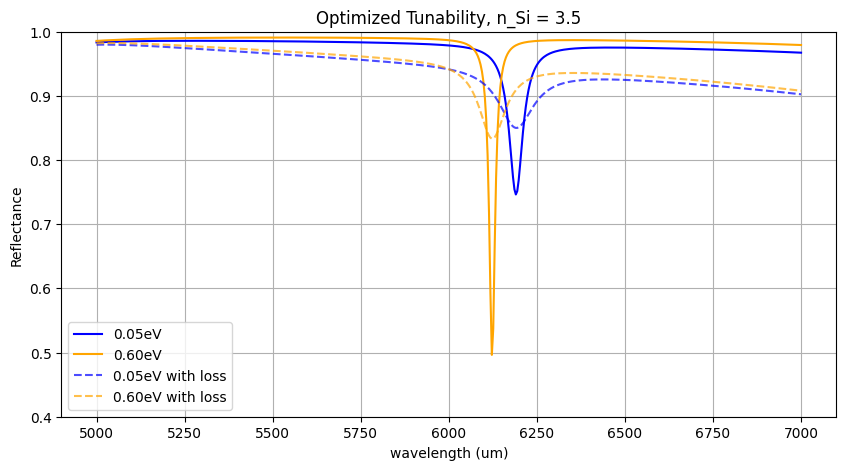

In [ ]:
# Plotting with matplotlib
plt.figure(figsize=(10, 5))
plt.plot(x_np, y_005_af, label='0.05eV', color='blue')
plt.plot(x_np, y_060_af, label='0.60eV',color='orange')
plt.plot(x_np, y_005_loss, label='0.05eV with loss', color='blue', ls = '--', alpha = 0.7)
plt.plot(x_np, y_060_loss, label='0.60eV with loss', color='orange', ls = '--', alpha = 0.7)
# plt.plot(x_np, y_005_0del, label='0.05eV 0 delta', color='blue', ls = ':', alpha = 0.5)
# plt.plot(x_np, y_060_0del, label='0.60eV 0 delta', color='orange', ls = ':', alpha = 0.5)
plt.title("Optimized Tunability, n_Si = 3.5")
plt.xlabel('wavelength (um)')
plt.ylabel('Reflectance')
plt.legend()
plt.grid(True)
plt.ylim([0.4,1])
plt.show()

In [ ]:
def calc_tunability(parameters):

    # Initialize parameters as tensors with requires_grad=True
    p = torch.tensor(parameters[0], requires_grad=True, dtype=torch.float64)
    delta = torch.tensor(parameters[1], requires_grad=True, dtype=torch.float64)
    d = torch.tensor(parameters[2], requires_grad=True, dtype=torch.float64)
    t = torch.tensor(parameters[3], requires_grad=True, dtype=torch.float64)
    w = torch.tensor(parameters[4], requires_grad=True, dtype=torch.float64)

    period_x = 2 * p
    period_y = torch.tensor(1, requires_grad=False, dtype=torch.float64)

    center = [[-1 * p / 2 * (1 - delta), period_y / 2], [p / 2 * (1 - delta), period_y / 2], [period_x / 2, period_y / 2], [period_x / 2, period_y / 2], [period_x / 2, period_y / 2]]
    length_x = [w, w, period_x, period_x, period_x]
    length_y = [period_y, period_y, period_y, period_y, period_y]

    # Calculate peaks and frequencies
    peak_005eV, _ = find_min_wl_005eV(center, length_x, length_y, period_x, period_y, d, t)
    peak_060eV, _ = find_min_wl_060eV(center, length_x, length_y, period_x, period_y, d, t)

    #print(peak_005eV, peak_060eV)

    peak_freq_005eV = 2 * torch.pi / peak_005eV
    peak_freq_060eV = 2 * torch.pi / peak_060eV
    
    print("Peak wavelengths: ",peak_005eV.item(), peak_060eV.item())

    FWHM_060 = find_FWHM_060eV(peak_060eV, center, length_x, length_y, period_x, period_y, d, t)
    FWHM_005 = find_FWHM_005eV(peak_005eV, center, length_x, length_y, period_x, period_y, d, t)
    tunability = (-peak_freq_060eV + peak_freq_005eV) * 2 / (FWHM_060 + FWHM_005 + 1e-10)  # Add small constant to avoid division issues
    print("FWHM: ",FWHM_005.item(), FWHM_060.item())
    return -1 * tunability.item()

In [ ]:
tunability = calc_tunability(best_parameters)

print(tunability)

Peak wavelengths:  6187.5439453125 6121.248046875
FWHM:  1.753879221971506e-05 1.6769838832388344e-05
0.641112132746052
